# Phishing Email Generation and Classification

Experimental notebook for classification and generation of phishing emails using several techniques.

Roadmap:
- Preprocessing
    - Sentiment Analysis
    - Extract features based on persuasive features of speech / common phishing tropes
    - Steal some feature ideas from webpage classification and apply these
- Classification
    - Logistic Regression on emails
    - word2vec/GLoVE word representation -> logistic regression
    - Transformer-based model (BERT)
    - Transfer learning
- Generation
    - With GANs
    - With T5
    - With transformers
- Adversarial Learning
    - EA-based method of classifying
    - Cyclical GANs
    - Use EA to seed an NN?

In [2]:
# Install requirements - uncomment this line the first time you run this notebook
# !pip install -r ./requirements.txt

In [3]:
#data
import pandas as pd
import numpy as np

#utilities
from functools import reduce
from tqdm import tqdm
import itertools
from collections import Counter
import pickle
import os
import re
import gc

# scikit
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.linear_model import LogisticRegression

# word embeddings
import gensim
import gensim.downloader as gensim_api
from gensim.models.word2vec import Word2Vec as w2v

#graphing
import matplotlib.pyplot as plt
%matplotlib inline

#nltk
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords as NLTK_STOP
import string

#spacy imports
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOP

In [4]:
myseed = 10897

# Email-Spam-Dataset

Use this dataset as preliminary exploration of classification techniques. Classifier can then be applied to Enron dataset if it works

0: not spam
1: spam

In [5]:
spam_col_names = ['id', 'Body', 'Label']

In [6]:
dfSA = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/completeSpamAssassin.csv', names=spam_col_names)

In [7]:
dfEnron = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/enronSpamSubset.csv', names=spam_col_names).tail(-1)

In [8]:
dfLing = pd.read_csv('./kaggle-datasets/Email-Spam-Dataset/lingSpam.csv', names=spam_col_names)

Take a peek at the body of the emails

In [9]:
dfLing.head()

,id,Body,Label
0,NaN,Body,Label
1,0.0,Subject: great part-time or summer job !\n \n ...,1
2,1.0,Subject: auto insurance rates too high ?\n \n ...,1
3,2.0,Subject: do want the best and economical hunti...,1
4,3.0,Subject: email 57 million people for $ 99\n \n...,1


In [18]:
dfEdu = pd.read_csv('./educational-institute-dataset/PhishingEmailData.csv', encoding="ISO-8859-1", usecols=['Email_Subject', 'Email_Content', 'Closing_Remarks'])

In [19]:
dfEdu

,Email_Subject,Email_Content,Closing_Remarks
0,URGENT REQUEST,Are you available ?\nNo calls text only 951307...,BEST REGARDS
1,Quick question,I'm in a meeting and need help getting some Am...,na
2,******Part time home work assistant needed******,Hello RECIPIENT\n\nI am urgently seeking for a...,Sincerely
3,Ê vendor payment,Are you around? I need to pay a vendor with th...,na
4,Quick question,I'm in a meeting and need help getting some Am...,na
...,...,...,...
184,Sales Contract PO:#224906999,2 new message,thanks
185,new bill from Ian,your bill is here,thank you
186,Re: Payment Invoice,please check your,Thank you
187,KSU Infringement,"email has been reposted , regulation",Sincerely


In [20]:
dfEdu['Body'] = dfEdu[dfEdu.columns[1:]].apply(
    lambda x: '\n'.join(x.dropna().astype(str)),
    axis=1
)

In [21]:
dfEdu.drop(columns=['Email_Subject', 'Email_Content', 'Closing_Remarks'])

,Body
0,Are you available ?\nNo calls text only 951307...
1,I'm in a meeting and need help getting some Am...
2,Hello RECIPIENT\n\nI am urgently seeking for a...
3,Are you around? I need to pay a vendor with th...
4,I'm in a meeting and need help getting some Am...
...,...
184,2 new message\nthanks
185,your bill is here\nthank you
186,please check your \nThank you
187,"email has been reposted , regulation\nSincerely"


## Process Enron Dataset

Extract the message bodies from the Enron dataset

The Enron dataset is very large. To save RAM, the first time you process it you can save it to a csv, then restart the jupyter and load it from CSV (so temporary rows are not stored in RAM)

In [11]:
def process_enron():
    dfEnronFull = pd.read_csv('./kaggle-datasets/The-Enron-Email-Dataset/emails.csv', usecols=['message'])

    #TODO: for now we are overwriting the message column for memory-saving purposes,
    # but in future we may wnat to extract other features from the message column such as email metadata
    #the issue is that no other datasets contain this data
    #TODO: even overwriting, this still seems to use the same amount of ram
    #TODO: when reading from csv in load_processed_enron it gets an index, but not when do initial read - here need to ensure has index
    dfEnronFull['message'] = dfEnronFull['message'].str.split("\n\n", n=1).str[1]
    dfEnronFull["id"] = dfEnronFull.index + 1
    dfEnronFull["label"] = 0

    dfEnronFull.to_csv('./Processed-Datasets/Enron-Bodies/emails.csv', columns=['message'])

    return dfEnronFull

In [13]:
def load_processed_enron():
    dfEnronFull = pd.read_csv('./Processed-Datasets/Enron-Bodies/emails.csv', usecols=['message'])
    dfEnronFull["id"] = dfEnronFull.index + 1
    dfEnronFull["Label"] = 0

    return dfEnronFull

In [14]:
#uncomment if you haven't run enron yet
# dfEnronFull = process_enron()

In [15]:
#comment if you're running enron for first time
dfEnronFull = load_processed_enron()

# Preprocessing

In avoidance of 'self-plagiarisation', much of the code for the `Dataset` class is adapted from my Text Processing Sentiment Analysis assignment. Code can be provided to markers on request

In [17]:
#download wordnet for lemmatization
#uncomment appropriate line if you get error: "Resource wordnet not found.", "Resource punkt not found.", etc...

# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')

In [18]:
#download spacy dataset
#uncomment the line below if you get error "Can't find model 'en_core_web_sm'"
# !python -m spacy download en_core_web_sm
# !python3 -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

`Dataset` Class - this takes a `Dataframe` and applies various preprocessing/feature selection techniques to it

In [19]:
class Dataset:
    def __init__(self, df, preprocessing=["lower"], feature_selection=["alltokens"], retList=False, skip_data_loading=False):
        if skip_data_loading:
            pass
        
        #read preprocessing and feature_selection configuration
        self.data = df
        self.preprocessing = preprocessing
        self.feature_selection = feature_selection
        self.retList = retList

        # === define various processors and regexes for various preprocessing/feature selection methods ===

        # NLTK Stemming Engine
        self.porter = PorterStemmer()

        #NLTK Lemmatizing Engine
        self.wn_lt = WordNetLemmatizer()

        #tokenizers

        #words regex - splits on word boundaries, doesn't include punctuation etc
        self.word_tokenizer = RegexpTokenizer(r'\w+')

        #create tokenizer based on NLTK-provided regex from Labs
        nltk_pat = r'''(?x) # set flag to allow verbose regexps
            (?:[A-Z]\.)+ # abbreviations, e.g. U.S.A.
            | \w+(?:-\w+)* # words with optional internal hyphens
            | \$?\d+(?:\.\d+)?%? # currency and percentages, e.g. $12.40, 82%
            | \.\.\. # ellipsis
            | [][.,;"'?():_`-]
            | [>]?[:;][\']?[\(\)\[\]]+ # these are separate tokens; includes ], [
            '''
        self.nltk_tokenizer = RegexpTokenizer(nltk_pat)

        #create tokenizer based on custom regex based on above, with less features
        custom_pat = r'''(?x)
                \w+(?:-\w+)*
                |\$?\d+(?:\.\d+)?%?
                |\.\.\.'''
        self.custom_tokenizer = RegexpTokenizer(custom_pat)

        # stop words - SPACY_STOP defined above in imports

        self.NLTK_ENGLISH_STOP = set(NLTK_STOP.words('english'))
    
    def preprocess_phrase(self, phrase):
        """define preprocessing function for phrases
        can call any number of these options - however, some may not combine well"""

        if self.preprocessing == []:
            #no preprocessing
            return phrase
        if "multi_space" in self.preprocessing:
            phrase = re.sub(' +', ' ', phrase)
        if "lower" in self.preprocessing:
            #lowercase
            phrase = phrase.lower()
        if "newlines" in self.preprocessing:
            phrase = " ".join(filter(None, phrase.split("\n")))
        if "returns" in self.preprocessing:
            phrase = " ".join(filter(None, phrase.split("\r")))
        if "punc" in self.preprocessing:
            #remove punctuation
            phrase = phrase.translate(str.maketrans('','',string.punctuation))
        if "stemming" in self.preprocessing:
            #use NLTK stemming
            phrase = self.porter.stem(phrase)
        if "nltk_lemmatize" in self.preprocessing:
            #use NLTK's lemmatization method
            new_phrase = ""
            words = nltk.word_tokenize(phrase)
            for word in words:
                new_phrase += self.wn_lt.lemmatize(word)
            phrase = new_phrase
        if "spacy_lemmatize" in self.preprocessing:
            #use spacy's lemmatization method
            nlp_phrase = nlp(phrase)
            new_phrase = ""
            for token in nlp_phrase:
                new_phrase += (token.lemma_ + " ")
            phrase = new_phrase

        return phrase

    def extract_features_from_phrase(self, phrase):
        """define feature extraction function for phrases
        extracts all words from all phrases as features for document set
        for each method, if one has already been applied the phrase must be treated as a list"""

        #list of negation words from 
        negation_words = ["neither", "never", "no", "nobody", "none", "noone", "nor", "not", "nothing", "nowhere"]

        intensifer_words = ["absolutely", "completely", "extremely", "highly", "rather", "really", "so", "too", "totally", "utterly", "very"]

        #TODO: add words for authority, bank accounts, urgency, click here, ...

        #use if len(self.feature_selection) > 1 to check if any preprocessing already occurred, as input will be in a list

        if self.feature_selection == []:
            #we have to do some feature selection, absolute minimum is alltokens
            return phrase.split(" ")
        if "alltokens" in self.feature_selection:
            #split based on whitespace
            phrase = phrase.split(" ")
        if "nltk_tokenize" in self.feature_selection:
            #tokenize using NLTK tokenizer, with words regex
            if isinstance(phrase, list):
                phrase =  list(itertools.chain.from_iterable([self.word_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.word_tokenizer.tokenize(phrase)
                # print(phrase)
        if "nltk_tokenize_2" in self.feature_selection:
            #tokenize using NLTK's regex
            if isinstance(phrase, list):
                phrase =  list(itertools.chain.from_iterable([self.nltk_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.nltk_tokenizer.tokenize(phrase)
        if "custom_tokenize" in self.feature_selection:
            #tokenize with custom regex
            if isinstance(phrase, list):
                phrase = list(itertools.chain.from_iterable([self.custom_tokenizer.tokenize(partial_phrase) for partial_phrase in phrase]))
            else:
                phrase = self.custom_tokenizer.tokenize(phrase)
        if "nltk_stoplist" in self.feature_selection:
            #use an NLTK stoplist
            if isinstance(phrase, list):#check words if already split into list
                #TODO: quicker way to run this?
                phrases = []
                for partial_phrase in phrase:
                    if partial_phrase not in self.NLTK_ENGLISH_STOP:
                        phrases.append(partial_phrase)
                phrase = phrases
            else:#split into list then eval words
                phrase = [word for word in phrase.split(" ") if word not in self.NLTK_ENGLISH_STOP]
        if "spacy_stoplist" in self.feature_selection:
            #use a spacy stoplist
            if isinstance(phrase, list):
                phrases = []
                for partial_phrase in phrase:
                    if partial_phrase not in list(SPACY_STOP):
                        phrases.append(partial_phrase)
                phrase = phrases
            else:
                phrase = [word for word in phrase.split(" ") if word not in list(SPACY_STOP)]
        if "custom_stoplist" in self.feature_selection:
            #use a custom stoplist
            stoplist = ["subject"]
            if isinstance(phrase, list):
                phrases = []
                for partial_phrase in phrase:
                    if partial_phrase not in stoplist:
                        phrases.append(partial_phrase)
                phrase = phrases
            else:
                phrase = [word for word in phrase.split(" ") if word not in stoplist]
        if "nltk_pos_tag" in self.feature_selection:
            #use POS tagging - must be a list, so split by spaces if not already
            if isinstance(phrase, list):
                phrase = nltk.pos_tag(phrase)
            else:
                phrase = phrase.split(" ")
                phrase = nltk.pos_tag(phrase)
        if "negation_bigrams" in self.feature_selection:
            #create bigrams with negation words + their successors
            if len(self.feature_selection) > 1:
                phrases = []
                for j in range(0, len(phrase)):
                    partial_phrase = phrase[j]
                    split = partial_phrase.split(" ")

                    for i in range(0, len(split)):
                        if split[i] in negation_words and i != len(split) - 1:
                            #add the negation word and its successor to the list of phrases
                            phrases.append(split[i] + " " + split[i+1])
                        else:
                            #skip to next partial if negation is at end of partial phrase
                            if split[i] in negation_words and j != len(phrase) - 1:
                                # print("Next partial")
                                phrases.append(split[i] + " " + phrase[j+1].split(" ")[0])
                            else:
                                #skip entirely if this is the last partial phrase
                                phrases.append(split[i])
                phrase = phrases
            else:
                split = phrase.split(" ")
                phrase = []
                for i in range(0, len(split)):
                    if split[i] in negation_words and i != len(split) - 1:
                        phrase.append(split[i] + " " + split[i+1])
                    else:
                        phrase.append(split[i])
        if "intensifier_bigrams" in self.feature_selection:
            #create bigrams with intensifier words + their successors
            if len(self.feature_selection) > 1:
                phrases = []
                for j in range(0, len(phrase)):
                    partial_phrase = phrase[j]
                    split = partial_phrase.split(" ")

                    for i in range(0, len(split)):
                        if split[i] in intensifer_words and i != len(split) - 1:
                            #add the intensifier word and its successor to the list of phrases
                            phrases.append(split[i] + " " + split[i+1])
                        else:
                            #skip to next partial if intensifier is at end of partial phrase
                            if split[i] in intensifer_words and  j != len(phrase) - 1:
                                phrases.append(split[i] + phrase[j+1].split(" ")[0])
                            else:
                                #skip entirely if this is the last partial phrase
                                phrases.append(split[i])
                phrase = phrases
            else:
                split = phrase.split(" ")
                phrase = []
                for i in range(0, len(split)):
                    if split[i] in intensifer_words and i != len(split) - 1:
                        phrase.append(split[i] + " " + split[i+1])
                    else:
                        phrase.append(split[i])
        if "remove_short_tokens" in self.feature_selection:
            #remove tokens with < 3 characters
            if len(self.feature_selection) > 1:
                phrases = []
                for j in range(0, len(phrase)):
                    partial_phrase = phrase[j]
                    split = partial_phrase.split(" ")

                    #recombine it, filtering out tokens of less than 3 characters, but keeping bigrams
                    recombined = " ".join([p for p in split if len(p) > 2])
                    phrases.append(recombined)
                phrase = phrases
            else:
                split = phrase.split(" ")
                phrase = [partial_phrase for partial_phrase in split if len(partial_phrase) > 2]

        if self.retList:
            return phrase
        
        #rejoin into one text body in case want to do different tokenisation/one-hot later on
        else:
            return " ".join(filter(None, phrase))
        
    #subclass must implement this
    def process_phrases(self):
        raise NotImplementedError
        
    #subclass must implement this
    def process_dataset(self):
        raise NotImplementedError

Subclass for emails

In [20]:
class EmailDataset(Dataset):
    def __init__(self, df, preprocessing=[], feature_selection=[], retList=False, bodyColumn='Body', skip_process_phrases=False, skip_data_loading=False):
        super().__init__(df, preprocessing, feature_selection, retList, skip_data_loading=skip_data_loading)
        self.bodyColumn = bodyColumn

        # === apply preprocessing and feature selection ===

        if not skip_process_phrases:
            self.process_phrases()

    def process_phrases(self):
        """extract bodies"""

        self.bodies = self.data[self.bodyColumn]
        
        #apply preprocessing function to all phrases using list comprehension
        self.preprocessed_phrases = [self.preprocess_phrase(phrase) for phrase in self.bodies]
        self.features = [self.extract_features_from_phrase(phrase) for phrase in self.preprocessed_phrases]

        data = {'id': self.data['id'], 'ppBody': self.features, 'label': self.data['Label']}
        self.pp_df = pd.DataFrame(data=data)

    def process_dataset(self):
        """applies post-processing to the dataframe rows"""

        #load the text body
        df = self.pp_df

        #find the negative and positive classes
        positive = df[df['label'] == "1"]
        negative = df[df['label'] == "0"]

        l_positive = len(positive)
        l_negative = len(negative)

        #which class is bigger?
        min_len = min(l_positive, l_negative)

        #take a random sample of the smaller class to remove class imbalance
        if l_positive > l_negative:
            positive = positive.sample(min_len, random_state=myseed)
        elif l_negative > l_positive:
            negative = negative.sample(min_len, random_state=myseed)

        #create counters from the text bodies
        self.pos_word_counter = positive['ppBody'].str.split().explode().value_counts()
        self.neg_word_counter = negative['ppBody'].str.split().explode().value_counts()

Subclass for sentiment analysis

In [21]:
class SentimentDataset(Dataset):
    def __init__(self, df, preprocessing, feature_selection, retList, bodyColumn='Phrase'):
        super().__init__(df, preprocessing, feature_selection, retList)

        self.bodyColumn = bodyColumn

        # === apply preprocessing and feature selection ===

        self.process_phrases()

    def process_phrases(self):
        # return super().process_phrases()
        #TODO: implement
        pass

# Word Representation Class

In [22]:
class WordRep:
    def __init__(self, corpus):
        self.corpus = corpus

In [23]:
class TFIDF(WordRep):
    def __init__(self, corpus, max_features=10000, ngram_range=(1,2)):
        super().__init__(corpus)

        self.vectorizer = feature_extraction.text.TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
        self.vectorizer.fit(self.corpus)

        self.representation = self.vectorizer.transform(self.corpus)
        self.vocabulary = self.vectorizer.vocabulary_

In [24]:
class Word2Vec(WordRep):
    def __init__(self, corpus):
        super().__init__(corpus)
    
    def create(self, name, size=300, window=8, min_count=1, sg=1, iter=5, callbacks=[]):
        self.representation = w2v(self.corpus, vector_size=size, window=window, min_count=min_count, sg=sg, epochs=iter, callbacks=callbacks)
        self.representation.save(f'./Word-Representations/{name}.model')

    def load(self, path):
        self.representation = w2v.load(path)

    def get_average_doc_embedding(self, document):
        embeddings = []
        for word in document.split(" "):
            if word in self.representation.wv:
                embeddings.append(self.representation.wv[word])
        
        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(self.representation.vector_size)

# Classifier Class

In [25]:
class Classifier:
    def __init__(self, dataset, word_rep, bodyColumn='ppBody'):
        self.dataset = dataset
        self.bodyColumn = bodyColumn

        self.split_data()

        self.word_rep = word_rep
    
    def split_data(self, label_index=-1):
        #get X and y dataframes - assumes label is last column
        self.X = self.dataset.pp_df.iloc[:, :label_index]
        self.y = self.dataset.pp_df.iloc[:, label_index]

        #random split
        ss = model_selection.ShuffleSplit(n_splits=1, test_size=0.25, random_state=myseed)
        indexes = list(ss.split(self.X, self.y))
        train_set  = indexes[0][0]
        test_set  = indexes[0][1]

        self.X_train = self.X.iloc[train_set, :]
        self.y_train = self.y.iloc[train_set]
        self.X_test = self.X.iloc[test_set, :]
        self.y_test = self.y.iloc[test_set]

    def get_numerical_rep(self, data, method='word_embedding'):
        if method == 'one_hot':
            #TODO add an option for one hot? not necessary
            pass
        elif method == 'word_embedding':
            rep = []

            docs = data[self.bodyColumn]
            for doc in docs:
                rep.append(self.word_rep.get_average_doc_embedding(doc))

        return rep

    def train(self, method='logistic_regression'):
        self.train_method = method

        if method == 'logistic_regression':
            self.train_embeddings = self.get_numerical_rep(self.X_train)
            self.model = LogisticRegression(random_state=0).fit(self.train_embeddings, self.y_train)
            
        if method == 'naive_bayes':
            self.method = naive_bayes.MultinomialNB()

            self.model = pipeline.Pipeline([("vectorizer", self.word_rep.vectorizer),
                                            ("classifier", self.method)])

            self.model["classifier"].fit(self.X_train, self.y_train)

    def predict(self, data, evaluate=False, labels=None):
        if self.train_method == 'logistic_regression':
            data = self.get_numerical_rep(data)
        else:
            data = data[self.bodyColumn]
            
        predicted = self.model.predict(data)

        if evaluate:
            if labels is None:
                print("Must supply labels option")
            else:
                accuracy = metrics.accuracy_score(labels, predicted)
                print(f"Model accuracy: {accuracy}")

        return predicted

# Utility Methods for Saving Models etc

Below methods allowed saving and loading the pickled counters, but this is less necessary now that `process_dataset()` is faster - can still be used to save objects

In [26]:
def save_pickle(object, path):
    if not os.path.exists('./Pickle'):
        os.makedirs('./Pickle')

    with open('./Pickle/' + path, 'wb') as output:
        pickle.dump(object, output)

In [27]:
def load_pickle(path):
    with open('./Pickle/' + path, 'rb') as input:
        return pickle.load(input)

Uncomment the below to save your counters to a file for later use

In [28]:
# save_pickle(d.pos_word_counter, 'd-pos.pickle')
# save_pickle(d.neg_word_counter, 'd-neg.pickle')
# save_pickle(d2.pos_word_counter, 'd2-pos.pickle')
# save_pickle(d2.neg_word_counter, 'd2-neg.pickle')

Uncomment the below to load your saved counters

In [29]:
# d1_pos_counts = load_pickle('d-pos.pickle')
# d1_neg_counts = load_pickle('d-neg.pickle')
# d2_pos_counts = load_pickle('d2-pos.pickle')
# d2_neg_counts = load_pickle('d2-neg.pickle')

# Instantiate some datasets 

Instantiate our dataset `d` with basic feature selection + tokenisation

In [30]:
#instantiate a new dataset
#run the preprocessing with lowercasing, removing newlines, stemming, and tokenisation using the nltk regex
# d = EmailDataset(dfSpam, preprocessing=["lower","newlines","stemming"], feature_selection=["nltk_tokenize"], retList=False)

In [31]:
# d2 = EmailDataset(dfSpam, preprocessing=["lower","newlines","stemming"], feature_selection=["nltk_tokenize", "nltk_stoplist"], retList=False)

In [32]:
# d3 = EmailDataset(dfSpam, preprocessing=["lower","newlines","stemming","returns"], feature_selection=["nltk_tokenize", "nltk_stoplist", "remove_short_tokens"], retList=False)

In [33]:
# d.process_dataset()

In [34]:
# d2.process_dataset()

In [35]:
# d3.process_dataset()

## Identifying Duplicates in Enron Dataset

As the Email-Spam-Dataset contains Enron emails marked as spam, we should remove these from the Enron dataset. Then we can relatively safely assume everything else in the Enron dataset is non-spam

The Enron dataset is very large. To save RAM, the first time you process it you can save it to a csv, then restart the jupyter and load it from CSV (so temporary rows are not stored in RAM)

In [37]:
def strip_spam_from_enron():
    dEnronSpam = EmailDataset(dfEnron, preprocessing=["lower","newlines","stemming","returns"], feature_selection=["nltk_tokenize", "nltk_stoplist", "remove_short_tokens", "custom_stoplist"], retList=False)
    
    dEnron = EmailDataset(dfEnronFull, preprocessing=["lower","newlines","stemming","returns"], feature_selection=["nltk_tokenize", "nltk_stoplist", "remove_short_tokens", "custom_stoplist"], retList=False, bodyColumn='message')

    #remove the items that appear in spam list, as best we can by comparing preprocessed email bodies - might not catch all of them
    #requires that the same preprocessing/feature selection is applied to dEnronSpam
    #making a big assumption here,but dataset is too big to manually inspect the duplicates
    dEnron.pp_df = dEnron.pp_df[~dEnron.pp_df.ppBody.isin(dEnronSpam.pp_df.ppBody)]

    dEnron.pp_df.to_csv('./Processed-Datasets/Enron-Bodies/enron-ham-only.csv')

    return dEnron

In [38]:
#uncomment this if you're stripping spam from enron for the first time
# strip_spam_from_enron()

In [39]:
def load_enron_ham_only():
    return pd.read_csv('./Processed-Datasets/Enron-Bodies/enron-ham-only.csv')

In [40]:
dEnronHam = load_enron_ham_only()

# Combine the datasets together

Once loaded the ham-only Enron (i.e. duplicates removed), combine them all and apply preprocessing (applying it twice to enron shouldn't matter)

In [41]:
all_dfs = [dEnronHam, dfEnron, dfLing, dfSpam]
dfAll = pd.concat(dfs).dropna(axis=0)

In [42]:
fullDataset = EmailDataset(dfAll, preprocessing=["lower","newlines","stemming","returns"], feature_selection=["nltk_tokenize", "nltk_stoplist", "remove_short_tokens"], retList=False)

# Instantiate Word Representations for each Dataset

In [43]:
from gensim.models.callbacks import CallbackAny2Vec

In [44]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

In [45]:
epoch_logger = EpochLogger()

Run the following to train a model:

In [53]:
def create_word2vec(data, name):
    """data: the ppBody column of a Dataset's pp_df dataframe
    name: where to save the model"""
    w2v_model = Word2Vec(data)
    w2v_model.create(name, callbacks=[epoch_logger])

    return w2v_model

In [54]:
w2v1 = create_word2vec(fullDataset.pp_df['ppBody'], 'fullDataw2v')

Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoch #14 end


In [51]:
w2v1

Load an existing model:

In [45]:
# w2v_1 = Word2Vec(d.pp_df['ppBody'])
# w2v_1.load('./Word-Representations/w2v_1.model')

Train the classifier

In [55]:
classifier_1 = Classifier(fullDataset, w2v1)

In [56]:
classifier_1.train()

In [57]:
predictions = classifier_1.predict(classifier_1.X_test, evaluate=True, labels=classifier_1.y_test)

Model accuracy: 0.6178425906069054


## Common Words

Pure count-based word analysis - better measure of informativeness can be achieved using TFIDF, but this also helps us identify what "useless" tokens we may have failed to remove

In [ ]:
def print_most_common_n(counter_df, n, name):
    print(f"{n} most common tokens in {name}:\n")

    head = counter_df.head(n)
    most_common = list(zip(head.index, head))

    if n < 6:
        output = ", ".join([f"\"{word}\" ({count})" for (word, count) in most_common])
    else:
        output = "\n".join([f"{word} ({count})" for (word, count) in most_common])

    print(output)

In [ ]:
print_most_common_n(d3.neg_word_counter, 20, "dfSpam (stopwords and short tokens removed) - non-Spam emails")

20 most common tokens in dfSpam (stopwords and short tokens removed) - non-Spam emails:

language (15162)
university (15135)
subject (14113)
http (12953)
enron (12349)
com (11705)
one (9584)
information (9021)
mail (8764)
www (8569)
would (8195)
new (8067)
please (8060)
linguistics (7967)
ect (7466)
conference (7023)
also (6845)
papers (6170)
may (6157)
english (5787)


In [ ]:
print_most_common_n(d3.pos_word_counter, 20, "dfSpam (stopwords and short tokens removed) - Spam emails")

20 most common tokens in dfSpam (stopwords and short tokens removed) - Spam emails:

subject (6630)
com (6141)
email (5354)
http (4930)
free (4511)
000 (4127)
mail (3959)
please (3949)
money (3929)
get (3915)
company (3898)
information (3878)
one (3670)
business (3606)
time (3371)
report (3130)
click (3111)
www (3088)
new (3087)
order (2751)


Histograms

<Axes: xlabel='ppBody'>

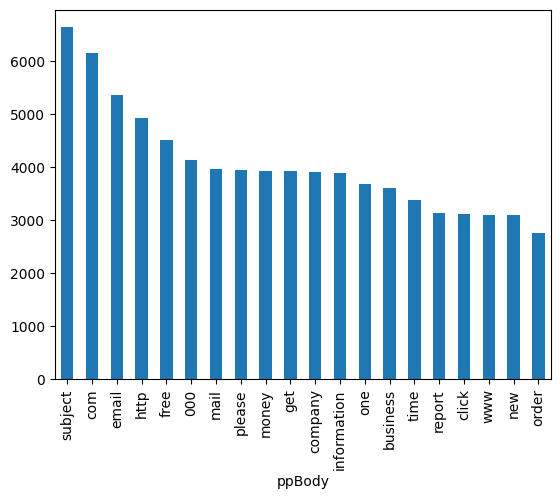

In [ ]:
d3.pos_word_counter.head(20).plot.bar()

# Sentiment Analysis

Define a Naive-Bayes based Sentiment-Analysis Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [ ]:
sent_raw = pd.read_csv("./kaggle-datasets/sentiment-analysis-on-movie-reviews/train.tsv", sep='\t')

#TODO: worth re-mapping the data to 3 classes?

sent_raw.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
sent_dataset = Dataset(sent_raw, preprocessing=["lower","punc"], feature_selection=["alltokens","custom_tokenize"], bodyColumn='Phrase')

KeyError: 'id'

## Training

Here we use a standard labelled dataset to train the NB model. We use the whole dataset for training and validation, and do not set aside a testing dataset, as we will test against the email datasets

Once we have defined a custom Sentiment measure, we can re-implement Naive Bayes with these 'custom' classes (for urgency, authority, scarcity, etc). We may use a naive dictionary-based system for labelling, and train based on this. However, we need to be careful with this approach as dictionary-based approaches struggle with things like sarcasm, negation, etc.

More 'objective' features, such as a count of the number of imperative words, may be a better metric here (saying "click here" in an email is unlikely to be sarcastic, and "do not click this link" is still potentially fishy - unless it is part of an advisory telling employees not to interact with phishing emails...).

Or, we may have to manually label a small training dataset.

# Persuasion

One of our metrics will be focused around detecting persuasive language. This paper is useful for this: https://convokit.cornell.edu/documentation/persuasionforgood.html

## Sentiment Analysis

# Email Classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit

In [ ]:
X = d.pp_df.iloc[:, 0:2]
y = d.pp_df.iloc[:, 2]

ss = ShuffleSplit(n_splits=1, test_size=0.25, random_state=10)
indexes = list(ss.split(X, y))
train_set  = indexes[0][0]
test_set  = indexes[0][1]
Xtrain = X.iloc[train_set, :]
ytrain = y.iloc[train_set]
Xtest = X.iloc[test_set, :]
ytest = y.iloc[test_set]

In [ ]:
d.pp_df

,id,ppBody,label
1.0,0.0,save up to 70 on life insurance why spend more...,1
2.0,1.0,1 fight the risk of cancer http www adclick ws...,1
3.0,2.0,1 fight the risk of cancer http www adclick ws...,1
4.0,3.0,adult club offers free membership instant acce...,1
5.0,4.0,i thought you might like these 1 slim down gua...,1
...,...,...,...
2601.0,2600.0,subject computationally intensive methods in q...,0
2602.0,2601.0,subject books a survey of american linguistics...,0
2603.0,2602.0,subject wecol 98 western conference on linguis...,0
2604.0,2603.0,subject euralex 98 revised programme euralex 9...,0


In [ ]:
d.pp_df.iloc[:, -1] == y

1.0       True
2.0       True
3.0       True
4.0       True
5.0       True
          ... 
2601.0    True
2602.0    True
2603.0    True
2604.0    True
2605.0    True
Name: label, Length: 18651, dtype: bool

## Word2Vec

Classify with word2vec (see https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)

## BERT

Classify with BERT (also using TDS article methods)

## Random Forest

Use RF/ensemble method for some of the classifiers above to see which features work best and which preprocessing methods are good - exploring Phishing-Dataset-for-Machine-Learning features first may be helpful

# Phishing-Dataset-for-Machine-Learning

Inspect this dataset - it is for webpages (https://www.sciencedirect.com/science/article/pii/S0020025519300763?via%3Dihub) but some of the features may be applicable to email classification

Other repos that use this dataset to take inspiration from:
- https://github.com/andpalmier/MLWithPhishing
- https://github.com/rewanthtammana/Detect-phishing-websites-using-ML
- https://www.kaggle.com/code/fadilparves/pishing-detection-using-machine-learning

Random forests used to discover best features - we could apply similar to the Email-Spam-Dataset

## New Feature Extraction

Can we apply the features used in this dataset to Email-Spam-Dataset?

# Transfer Learning

Use a pretrained word representation and replace the classification layer, then fine-tune the model.

# Comments



# Todo

- [x] Remove NaN id from merged `dfSpam`
- [ ] Tokenise body data
- [ ] Set seed method
- [ ] Stratified Sample?